#Import Data

In [1]:
from google.colab import drive, files
import pandas as pd
import numpy as np
import requests 

drive.mount('/content/drive/')
f = open("/content/drive/My Drive/Colab Notebooks/OnlineNewsPopularity_original.csv")
dataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/OnlineNewsPopularity_original.csv")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In the beginging, we import the dataset and delect the first two columns, which are url and delta time (the time when the articles are posted.)  

In [0]:
import seaborn as sns
from scipy import stats
from scipy.stats import norm
X = dataset.loc[:," n_tokens_title":" shares"]

# Data Pre-processing

##Missing Values Issue
There's lots 0 in the columns, and by the definition, we can view them as missing values. For example. the **"n_unique_tokens"** represents the rates of unique words in an article. It could not equal to zero, otherwise, it would be only an online news video.

In [0]:
#change the 0 in np.nan
df0 = dataset.loc[:," n_tokens_title":" shares"]
df0[" n_unique_tokens"].replace(0, np.nan, inplace= True)
df1 = df0.dropna()

By ploting the **"n_unique_tokens"**, you can see

fig, axes = plt.subplots(1,2)
plt.xlim(0, 20)
plt.ylim(0, 0.5)
sns.distplot(df1[" n_non_stop_words"],ax=axes[0])
sns.distplot(df1[" n_non_stop_words"],ax=axes[1])

## Outlier Issue
After we filiter some missing values, there're some outliers needed to be took care.

In [4]:
#Method1
anomalies = []
def find_anomalies(random_data):
    # Set upper and lower limit to 3 standard deviation
    random_data_std = np.std(random_data)
    random_data_mean = np.mean(random_data)
    anomaly_cut_off = random_data_std * 3
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    print(lower_limit)
    # Generate outliers
    for outlier in random_data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return anomalies

find_anomalies(df1[' n_unique_tokens'])

-10.153877015441713


[701.0]

In [0]:
#Method2
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [0]:
df2 = remove_outlier(df1,' n_unique_tokens')

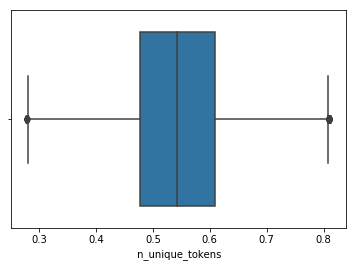

In [6]:
sns.boxplot(df2[" n_unique_tokens"])

In [0]:
df1.describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000
mean,10.382419,563.295375,0.565049,1.027065,0.710336,11.217872,3.394769,4.563061,1.263786,4.687892,7.215012,0.054000,0.178249,0.162104,0.060084,0.190443,0.212360,26.708187,1151.751079,313.946906,13182.545563,750317.505135,255215.159411,1102.009897,5603.782810,3103.427793,4121.536513,10646.369414,6598.260636,0.168240,0.186439,0.187323,0.183345,0.143983,0.061592,0.069079,0.130671,0.188134,0.141680,0.217177,0.214291,0.238692,0.456984,0.122973,0.040842,0.017122,0.703096,0.296774,0.364689,0.098376,0.779963,-0.267493,-0.537970,-0.110801,0.280573,0.070997,0.342431,0.154930,3355.360398
std,2.113800,468.299538,3.573022,5.307978,3.312293,11.340580,3.869773,8.295365,4.164896,0.283231,1.916459,0.226021,0.382727,0.368551,0.237645,0.392655,0.408984,70.278215,3870.494630,624.449580,56850.480221,216395.888328,131821.240188,1127.031740,6096.725673,1301.238777,20026.792850,41612.149801,24553.836601,0.374084,0.389466,0.390176,0.386954,0.351077,0.240416,0.253592,0.337045,0.265547,0.220360,0.282238,0.288938,0.291382,0.088386,0.096091,0.016229,0.010588,0.150208,0.150032,0.085455,0.070382,0.212509,0.121174,0.279703,0.094919,0.323561,0.264338,0.188606,0.225636,11585.968776
min,2.000000,18.000000,0.114964,1.000000,0.119134,0.000000,0.000000,0.000000,0.000000,3.600000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.393750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,9.000000,259.000000,0.477419,1.000000,0.632588,5.000000,1.000000,1.000000,0.000000,4.496250,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,445.000000,143.000000,0.000000,843300.000000,171300.000000,0.000000,3549.290325,2373.807082,703.000000,1200.000000,1100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025060,0.025012,0.028572,0.025622,0.028575,0.402457,0.064394,0.029463,0.010177,0.612903,0.200000,0.3

In [0]:
df2.describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,37973.000000,37973.000000,37973.000000,3.797300e+04,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000
mean,10.391331,560.569168,0.545647,1.000000e+00,0.693257,11.271008,3.398783,4.444026,1.268586,4.686986,7.212309,0.054302,0.177863,0.163722,0.059648,0.191188,0.213862,26.486583,1150.473672,313.510178,13172.856108,750978.837595,255218.120601,1099.357765,5599.764733,3099.610745,4135.327520,10707.044341,6628.229204,0.168277,0.186843,0.187870,0.183551,0.143839,0.061623,0.067996,0.129618,0.189295,0.140345,0.218339,0.212341,0.239680,0.456871,0.123034,0.040752,0.017071,0.703094,0.296827,0.364671,0.097594,0.781466,-0.267711,-0.539690,-0.110302,0.279682,0.070781,0.343169,0.154221,3330.900350
std,2.109923,443.967139,0.096589,3.474503e-09,0.095087,11.310938,3.812256,7.784003,4.186716,0.281763,1.915553,0.226615,0.382403,0.370028,0.236836,0.393242,0.410036,70.028090,3888.175517,627.195579,56889.676371,215915.851286,131686.585290,1125.638855,6122.752002,1304.243869,20142.471513,41858.420567,24696.328412,0.374117,0.389791,0.390614,0.387123,0.350931,0.240472,0.251742,0.335888,0.266334,0.218985,0.282866,0.288151,0.291766,0.087703,0.094701,0.015973,0.010347,0.148411,0.148303,0.084810,0.069031,0.211355,0.119970,0.278762,0.093431,0.323551,0.263679,0.188304,0.225281,11082.323346
min,2.000000,29.000000,0.277099,9.999999e-01,0.277202,0.000000,0.000000,0.000000,0.000000,3.600000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018182,0.018182,0.018182,0.018182,0.018182,0.000000,-0.393750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,9.000000,262.000000,0.477695,1.000000e+00,0.632953,5.000000,1.000000,1.000000,0.000000,4.496183,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,445.000000,142.833333,0.000000,843300.000000,171340.000000,0.000000,3544.719512,2370.614772,705.000000,1200.000000,1100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025065,0.025012,0.028572,0.025534,0.028576,0.402536,0.064570,0.029499,0.010204,0.612

## Convert dummy variables back to categorical data

In [23]:
ch = df2[[' data_channel_is_lifestyle',
          ' data_channel_is_entertainment',
          ' data_channel_is_bus',
          ' data_channel_is_socmed',
          ' data_channel_is_tech',
          ' data_channel_is_world']]
ch.rename(columns={' data_channel_is_lifestyle':'lifestyle',
                   ' data_channel_is_entertainment':'entertainment',
                   ' data_channel_is_bus':'business',
                   ' data_channel_is_socmed':'social media',
                   ' data_channel_is_tech':'tech',
                   ' data_channel_is_world':'world'}, inplace=True)
ch = ch.idxmax(axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [24]:
ch.value_counts()

world            8121
lifestyle        7356
tech             7260
entertainment    6754
business         6217
social media     2265
dtype: int64

In [0]:
ch = pd.DataFrame(ch, columns=['channels'])
df3 = pd.concat([df2, ch], axis=1, sort=False,)

# Data Visulization

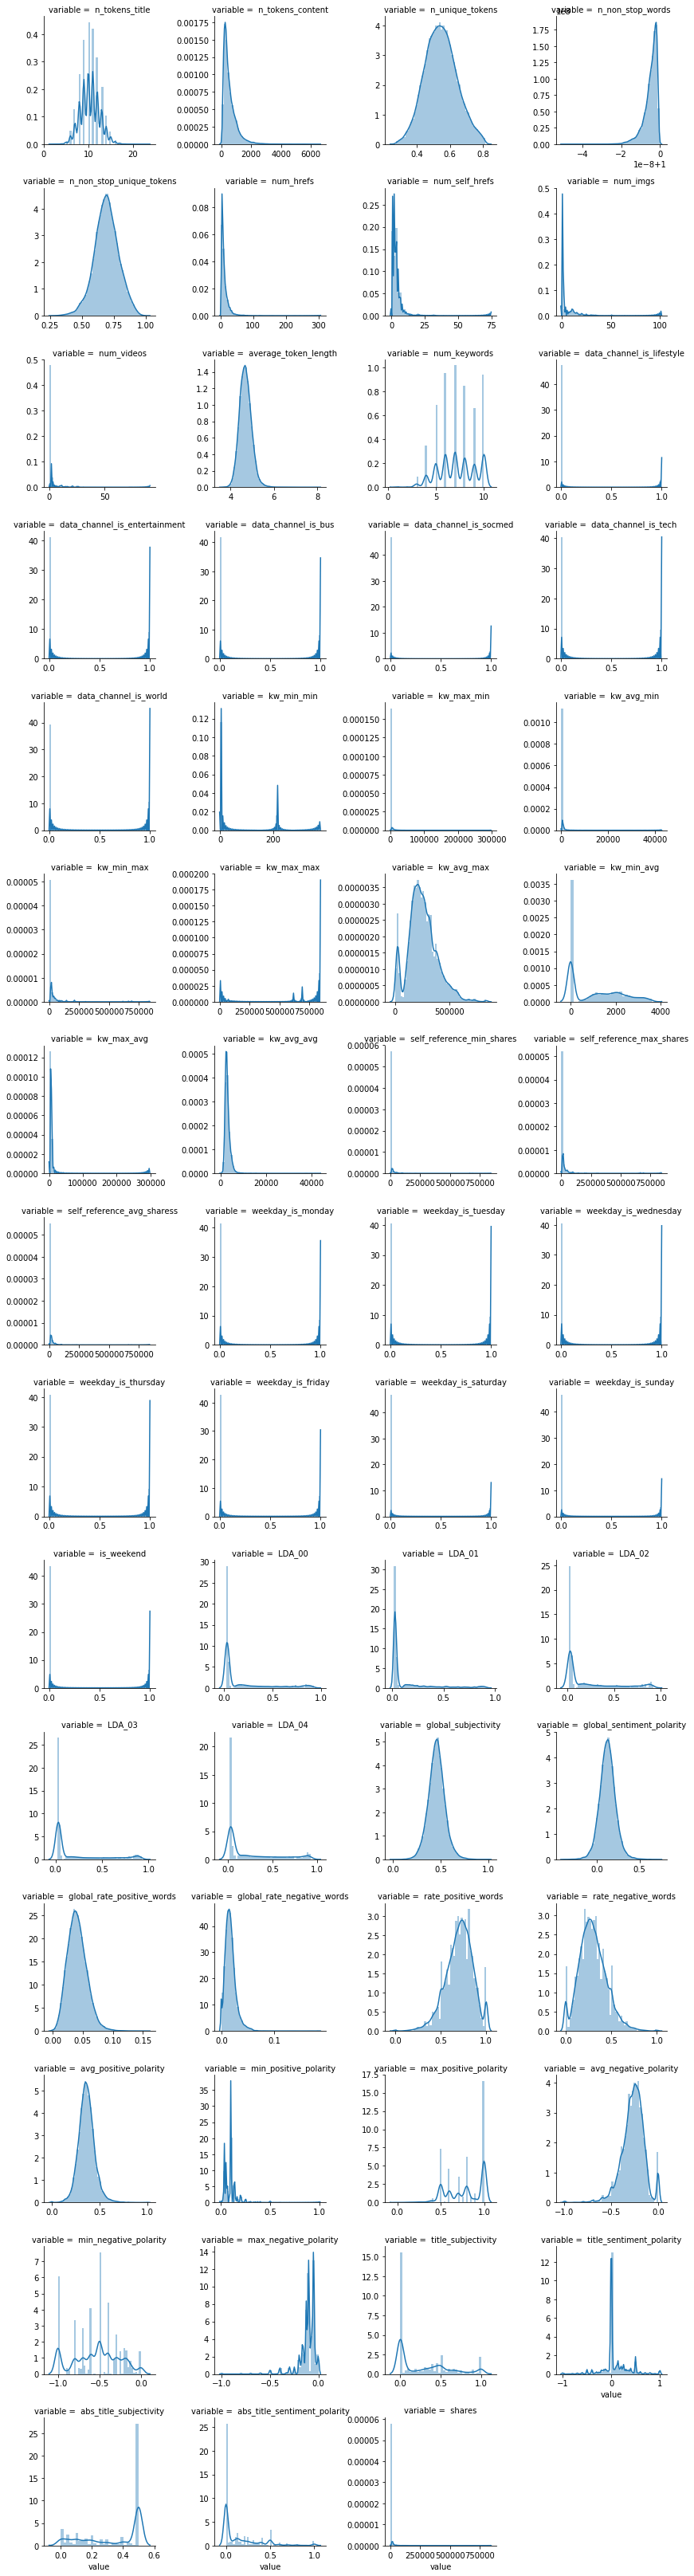

In [0]:
#distribution plots for each columns
num = [f for f in df2.columns if df2.dtypes[f] != 'object']
nd = pd.melt(df2, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

In [30]:
mask = df3[' shares']>= 29000
print('The total shares of articles with over 29000 shares:', df3[mask][' shares'].sum())
print('The count shares: ', df3[mask][' shares'].count())
print('The average shares: ',df3[mask][' shares'].mean())
print('')
print('The total shares of articles with less 29000 shares:', df3[~mask][' shares'].sum())
print('The count shares: ', df3[~mask][' shares'].count())
print('The average shares',df3[~mask][' shares'].mean())
df3[' shares'].mean()

The total shares of articles with over 29000 shares: 28257796
The count shares:  424
The average shares:  66645.74528301887

The total shares of articles with less 29000 shares: 98226483
The count shares:  37549
The average shares 2615.9546991930542


3330.900350248861

In [0]:
df4 = df3[:]
df4 = df4.assign(IsAtLeast29000 = lambda x: x[' shares']>= 29000)

In [0]:
df41 = df4.groupby('IsAtLeast29000')[' shares'].agg(['count','sum','mean'])

In [0]:
df41['count_percentage'] = df41['count']/df41['count'].sum()
df41['sum_percentage'] = df41['sum']/df41['sum'].sum()

In [40]:
df41

,count,sum,mean,count_percentage,sum_percentage
IsAtLeast29000,,,,,
False,37549,98226483,2615.954699,0.988834,0.77659
True,424,28257796,66645.745283,0.011166,0.22341


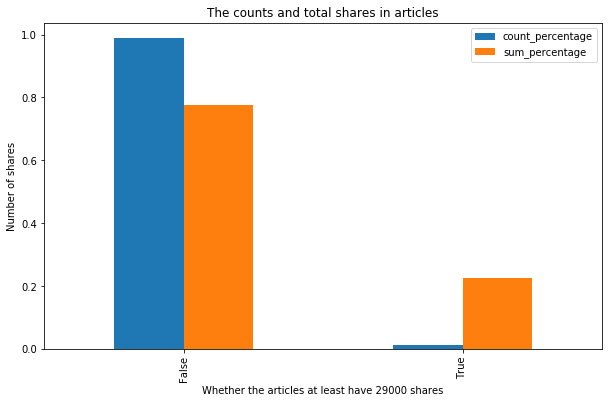

In [60]:
import matplotlib.pyplot as plt
df42 = df41[["count_percentage","sum_percentage"]]
df42.plot(kind='bar', figsize=(10, 6))
 
plt.xlabel('Whether the articles at least have 29000 shares') # add to x-label to the plot
plt.ylabel('Number of shares') # add y-label to the plot
plt.title('The counts and total shares in articles') # add title to the plot
 
plt.show()

## Split data into train and test dataset

In [0]:
df4['IsAtLeast29000'] = df4['IsAtLeast29000'].astype('float')

In [0]:
from sklearn import model_selection

# Split-out validation dataset
array = df4.values
X = df4.loc[:," n_tokens_title":" data_channel_is_world"]
Y = df4.loc[:,"IsAtLeast29000"]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [102]:
X.describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday
count,37973.000000,37973.000000,37973.000000,3.797300e+04,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000,37973.000000
mean,10.391331,560.569168,0.545647,1.000000e+00,0.693257,11.271008,3.398783,4.444026,1.268586,4.686986,7.212309,0.054302,0.177863,0.163722,0.059648,0.191188,0.213862,26.486583,1150.473672,313.510178,13172.856108,750978.837595,255218.120601,1099.357765,5599.764733,3099.610745,4135.327520,10707.044341,6628.229204,0.168277,0.186843,0.187870,0.183551,0.143839,0.061623,0.067996
std,2.109923,443.967139,0.096589,3.474503e-09,0.095087,11.310938,3.812256,7.784003,4.186716,0.281763,1.915553,0.226615,0.382403,0.370028,0.236836,0.393242,0.410036,70.028090,3888.175517,627.195579,56889.676371,215915.851286,131686.585290,1125.638855,6122.752002,1304.243869,20142.471513,41858.420567,24696.328412,0.374117,0.389791,0.390614,0.387123,0.350931,0.240472,0.251742
min,2.000000,29.000000,0.277099,9.999999e-01,0.277202,0.000000,0.000000,0.000000,0.000000,3.600000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,262.000000,0.477695,1.000000e+00,0.632953,5.000000,1.000000,1.000000,0.000000,4.496183,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,445.000000,142.833333,0.000000,843300.000000,171340.000000,0.000000,3544.719512,2370.614772,705.000000,1200.000000,1100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,424.000000,0.542416,1.000000e+00,0.693333,8.000000,3.000000,1.000000,0.000000,4.673333,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,659.000000,237.000000,1400.000000,843300.000000,242118.714286,1005.000000,4300.000000,2845.279892,1300.000000,3000.000000,2300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.000000,727.000000,0.609375,1.000000e+00,0.755435,14.000000,4.000000,4.000000,1.000000,4.859813,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1000.000000,358.000000,7700.000000,843300.000000,326780.000000,2026.176471,5958.745342,3542.143294,2700.000000,8200.000000,5325.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,23.000000,6505.000000,0.811594,1.000000e+00,1.000000,304.000000,74.000000,101.000000,91.000000,8.041534,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,377.000000,298400.000000,42827.857143,843300.000000,843300.000000,843300.000000,3613.039820,298400.000000,43567.659946,843300.000000,843300.000000,843300.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Build Models

In [0]:
# Load libraries
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [118]:

# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

# Spot Check Algorithms

models = []
models.append(('LR', LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter = 100000)))
#models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC(gamma='auto')))
#evaluate each model in turn
results = []
names = []

for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: 0.988610 (0.001904)
KNN: 0.988511 (0.002043)
CART: 0.975081 (0.003667)
NB: 0.961682 (0.004469)


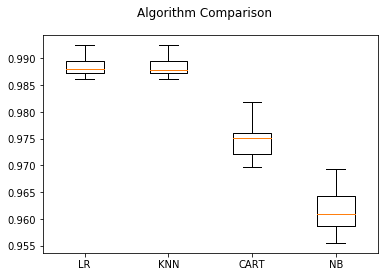

In [119]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [120]:
# KNN: Make predictions on validation dataset
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
predictions = knn.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.989466754443713
[[7515    1]
 [  79    0]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      7516
         1.0       0.00      0.00      0.00        79

    accuracy                           0.99      7595
   macro avg       0.49      0.50      0.50      7595
weighted avg       0.98      0.99      0.98      7595

